In [3]:
import sys
sys.path.append("../../pygenesig/")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import re

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

# Validate signatures based on FANTOM5 primary cells
This notebook aims at finding which samples from the FANTOM5 primary cells can be used to create meaningful signatures. 
We do this using cross-validation with two folds (there are often only two samples). 

When a signature is able to identify itself, the samples are 'good' and the signature appears to work. 

We first perform the crossvalidation and discard all samples that we could not validate and then re-create the signatures for the samples we did not discard. 

### Load data

In [4]:
expr_file = "../data/pygenesig/primary_exprs.npy"
target_file = "../data/pygenesig/primary_target_coarse.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=2)

In [5]:
expr = np.load(expr_file)
target = np.genfromtxt(target_file,  dtype=str, delimiter=",")

### perform cross-validation
... using *pygenesig*

We calculate the BioQC score for all signatures and all samples. We collapse samples of the same cell type, s.t we get a $n \times n$ scoring matrix. 

In [6]:
signatures = []
scores = []
score_mats = []
sg = GiniSignatureGenerator(expr, target, aggregate_fun=np.median)
st = BioQCSignatureTester(expr, target)
for train, test in splitter.split(list(enumerate(target)), target):
    signature = sg.mk_signatures(train)
    score = st.score_signatures(signature, test)
    signatures.append(signature)
    sig_labels = st.sort_signatures(signature)
    scores.append(score)
    scores_df = pd.DataFrame(np.transpose(score))
    scores_df.columns = sig_labels
    scores_df['tissue'] = pd.Series(target[test])
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    score_mats.append(scores_per_sig)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


### Average the scoring matrices and visualize it

In [7]:
avg = (score_mats[0] + score_mats[1])/2

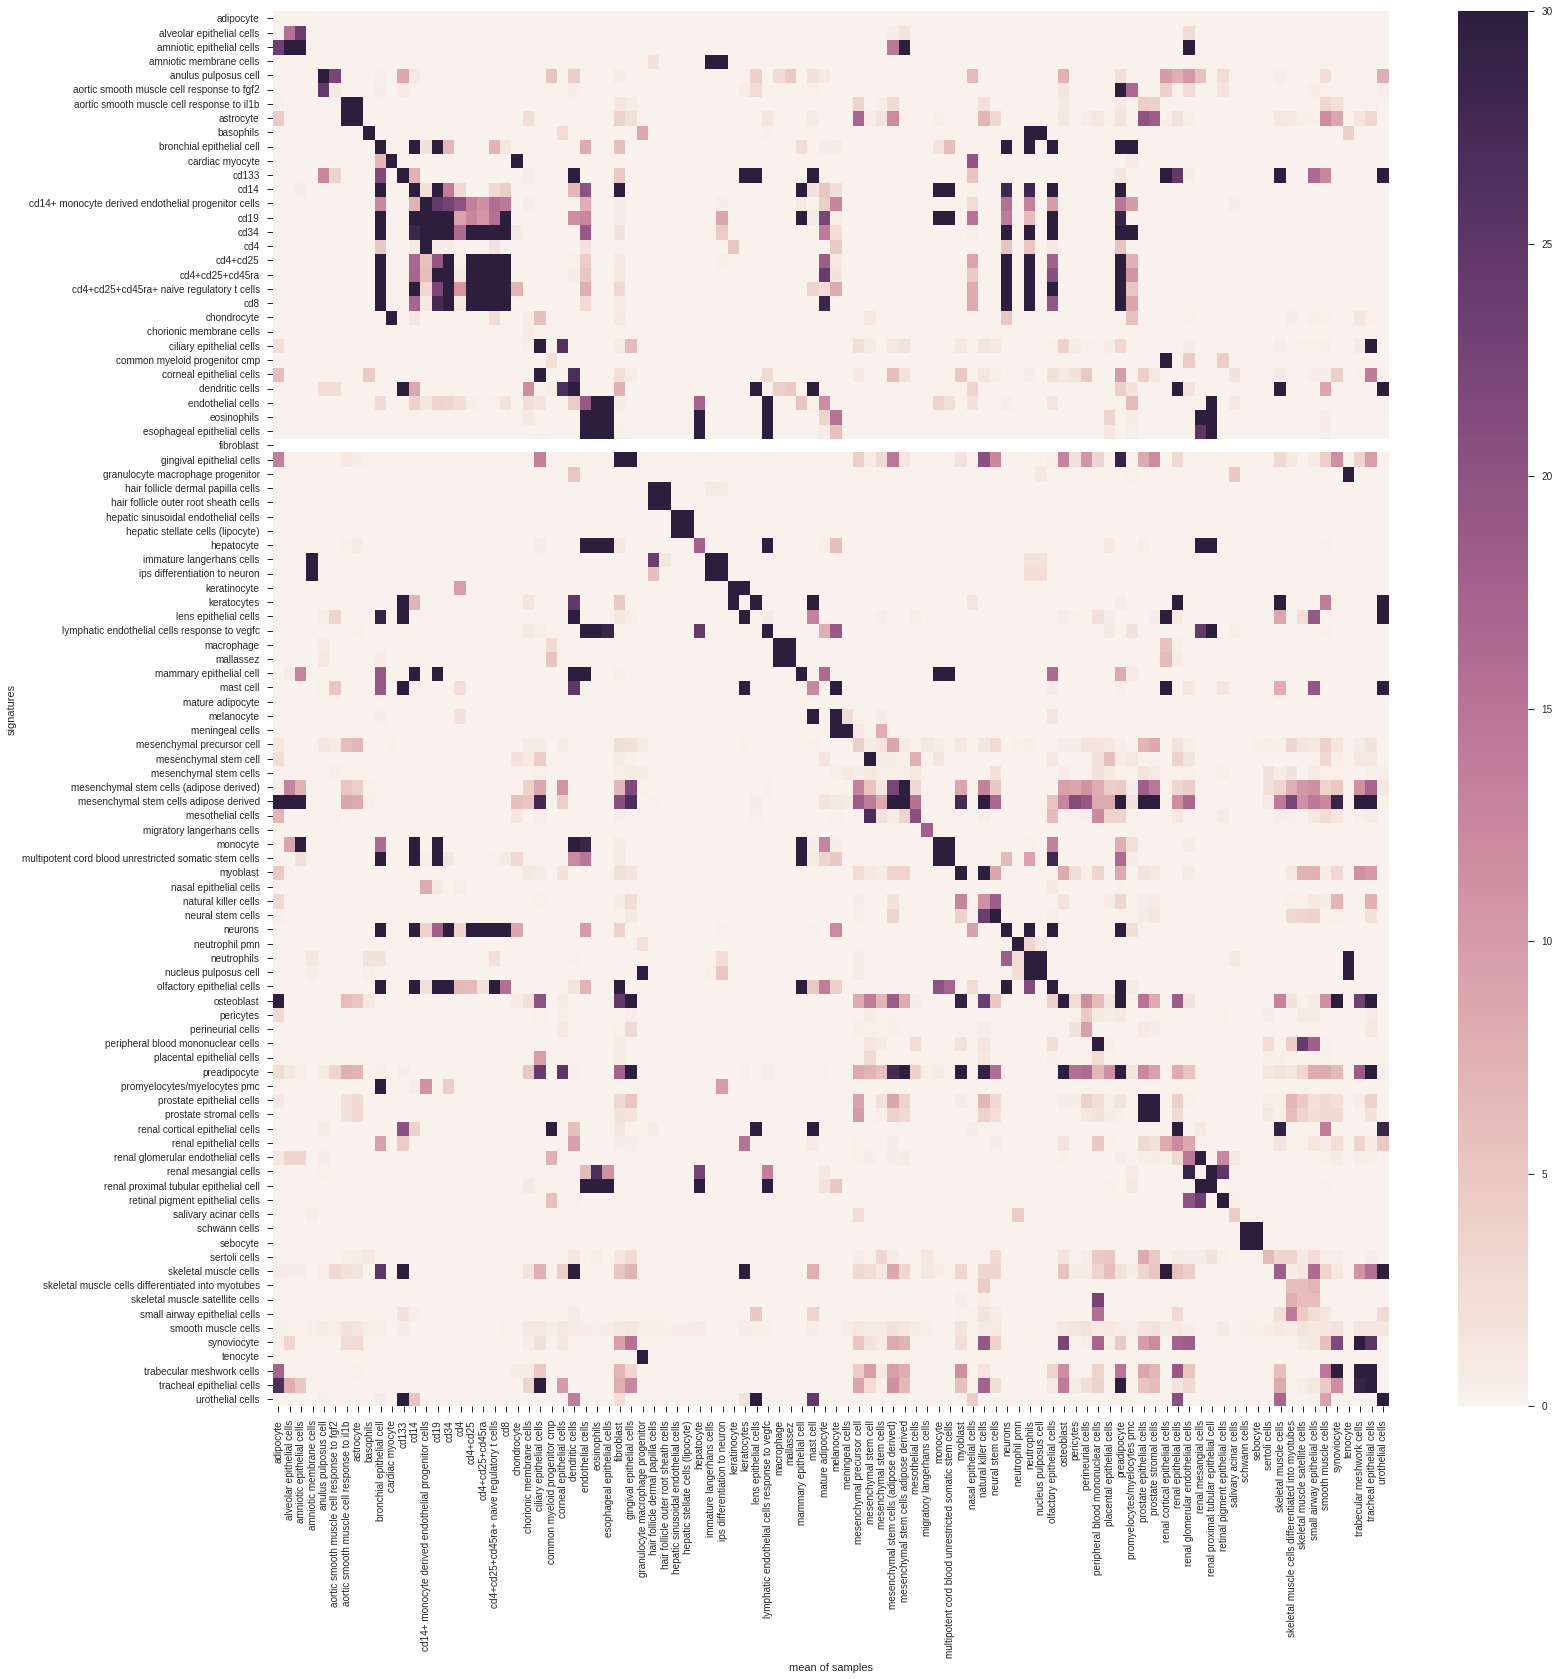

In [8]:
fig, ax = subplots(figsize=(25, 25))
sns.heatmap(avg, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

Fibroblast shows *NaN* as the signature does not contain a single gene in the first fold. 

The scoring matrix: 

In [9]:
pd.set_option('display.max_rows', 100)
avg

tissue,adipocyte,alveolar epithelial cells,amniotic epithelial cells,amniotic membrane cells,anulus pulposus cell,aortic smooth muscle cell response to fgf2,aortic smooth muscle cell response to il1b,astrocyte,basophils,bronchial epithelial cell,...,skeletal muscle cells,skeletal muscle cells differentiated into myotubes,skeletal muscle satellite cells,small airway epithelial cells,smooth muscle cells,synoviocyte,tenocyte,trabecular meshwork cells,tracheal epithelial cells,urothelial cells
adipocyte,4.732686e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
alveolar epithelial cells,1.120539e-01,1.538917e+01,2.362108e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
amniotic epithelial cells,2.337656e+01,inf,inf,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.041737e-13,0.000000e+00,1.962856e-12,6.989305e-10,2.121520e-15,1.662925e-11,0.000000e+00,4.852005e-08,0.000000e+00
amniotic membrane cells,0.000000e+00,0.000000e+00,0.000000e+00,9.823783e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.382975e-06,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,6.027047e-18,0.000000e+00,0.000000e+00,2.770360e-04,0.000000e+00,0.000000e+00,0.000000e+00
anulus pulposus cell,6.254869e-14,0.000000e+00,0.000000e+00,1.205409e-17,9.131767e+01,2.234698e+01,2.410819e-17,1.446491e-16,0.000000e+00,3.929359e-01,...,5.853874e-01,0.000000e+00,4.339474e-16,1.598443e-01,2.273810e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.840258e+00
aortic smooth muscle cell response to fgf2,1.779540e-12,0.000000e+00,0.000000e+00,0.000000e+00,2.439272e+01,9.956920e-01,1.928655e-16,4.699887e-11,0.000000e+00,6.444030e-01,...,1.880022e-01,4.947024e-10,0.000000e+00,5.247100e-01,1.665876e-01,2.060545e-09,0.000000e+00,0.000000e+00,0.000000e+00,5.526304e-01
aortic smooth muscle cell response to il1b,2.914564e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.043231e-12,1.311534e-12,4.583259e+01,4.886614e+01,1.428489e-07,0.000000e+00,...,2.134832e-02,3.084228e-04,1.328998e-05,1.411684e-02,3.168610e+00,2.109115e+00,0.000000e+00,3.101790e-02,1.299386e-01,0.000000e+00
astrocyte,4.567318e+00,1.409157e-07,2.156469e-06,0.000000e+00,2.439518e-04,1.394280e-04,1.138549e+02,1.487628e+02,8.561808e-06,0.000000e+00,...,1.191862e+00,9.724713e-01,4.294003e-01,2.656706e-01,1.174328e+01,8.750208e+00,8.437865e-17,1.603926e+00,3.095009e+00,1.222817e-05
basophils,0.000000e+00,0.000000e+00,0.000000e+00,2.348065e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.247308e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.936590e+00,0.000000e+00,0.000000e+00,0.000000e+00
bronchial epithelial cell,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,inf,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## filter samples
1) require samples to identify themselves with a p-value of < 1e-4

In [10]:
avg_fil = avg

In [11]:
avg_fil = avg_fil[avg_fil.as_matrix().diagonal() > 4]

2) require gini > .85 (remove non-informative cell types)

In [12]:
avg_fil = avg_fil[avg_fil.applymap(lambda x: 100 if x > 100 else x).apply(gini, axis=1) > .85]

In [13]:
avg_fil

tissue,adipocyte,alveolar epithelial cells,amniotic epithelial cells,amniotic membrane cells,anulus pulposus cell,aortic smooth muscle cell response to fgf2,aortic smooth muscle cell response to il1b,astrocyte,basophils,bronchial epithelial cell,...,skeletal muscle cells,skeletal muscle cells differentiated into myotubes,skeletal muscle satellite cells,small airway epithelial cells,smooth muscle cells,synoviocyte,tenocyte,trabecular meshwork cells,tracheal epithelial cells,urothelial cells
alveolar epithelial cells,1.120539e-01,1.538917e+01,2.362108e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
amniotic epithelial cells,2.337656e+01,inf,inf,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.041737e-13,0.000000e+00,1.962856e-12,6.989305e-10,2.121520e-15,1.662925e-11,0.000000e+00,4.852005e-08,0.000000e+00
anulus pulposus cell,6.254869e-14,0.000000e+00,0.000000e+00,1.205409e-17,9.131767e+01,2.234698e+01,2.410819e-17,1.446491e-16,0.000000e+00,3.929359e-01,...,5.853874e-01,0.000000e+00,4.339474e-16,1.598443e-01,2.273810e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.840258e+00
aortic smooth muscle cell response to il1b,2.914564e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.043231e-12,1.311534e-12,4.583259e+01,4.886614e+01,1.428489e-07,0.000000e+00,...,2.134832e-02,3.084228e-04,1.328998e-05,1.411684e-02,3.168610e+00,2.109115e+00,0.000000e+00,3.101790e-02,1.299386e-01,0.000000e+00
astrocyte,4.567318e+00,1.409157e-07,2.156469e-06,0.000000e+00,2.439518e-04,1.394280e-04,1.138549e+02,1.487628e+02,8.561808e-06,0.000000e+00,...,1.191862e+00,9.724713e-01,4.294003e-01,2.656706e-01,1.174328e+01,8.750208e+00,8.437865e-17,1.603926e+00,3.095009e+00,1.222817e-05
basophils,0.000000e+00,0.000000e+00,0.000000e+00,2.348065e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.247308e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.936590e+00,0.000000e+00,0.000000e+00,0.000000e+00
bronchial epithelial cell,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,inf,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cardiac myocyte,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.819280e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cd133,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.242909e+01,3.669379e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.171936e+01,...,4.490134e+01,0.000000e+00,0.000000e+00,1.645948e+01,1.251820e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.116144e+02
cd14,0.000000e+00,7.473538e-16,5.268136e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,inf,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.214425e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Display scoring matrix of the 'high quality' samples

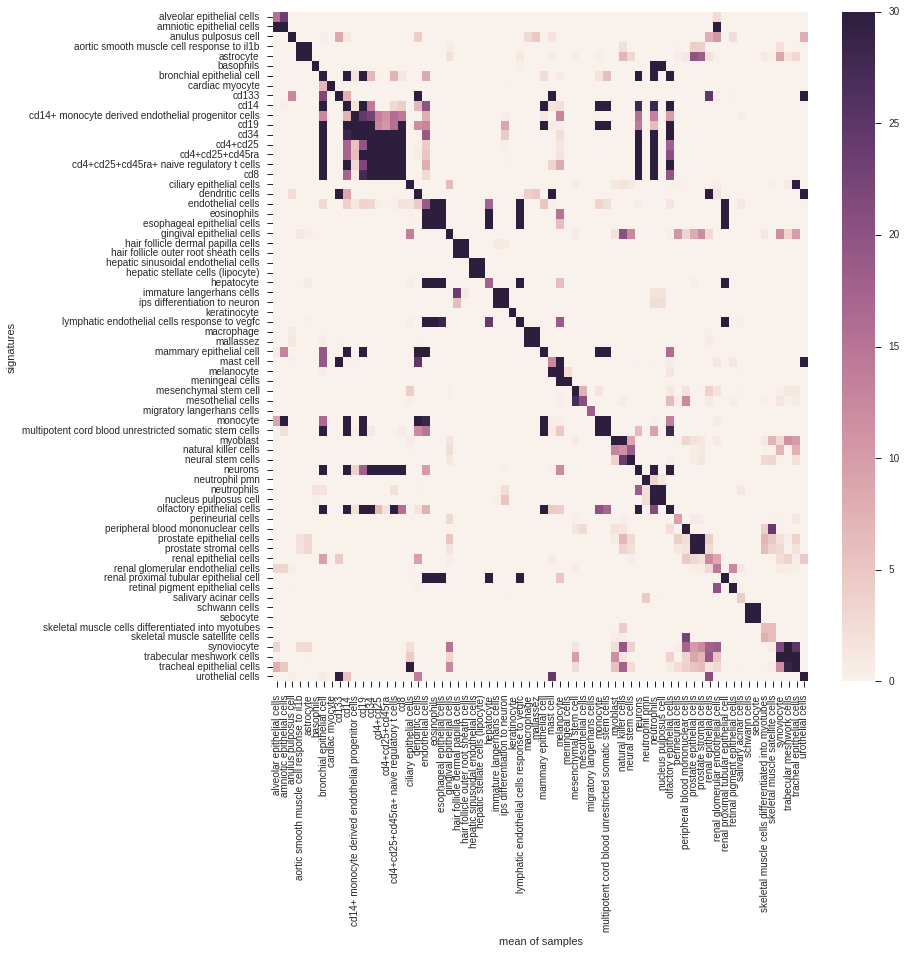

In [14]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(avg_fil.loc[:, avg_fil.index], ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## filter samples and re-calculate signatures

We assume, that samples on which we were not able to calculate signatures are *bad* samples. Here we generate a list of the underlying sample id's, s.t. we can exclude them from a the dataset. 

In the next step, we calculate the signatures on the *good* samples (using both folds) to export them as gmt file. 

In [15]:
def get_id(name): 
    RGX = re.compile(r'CNhs(\d+)\.(.+)')
    return RGX.search(name).group()

In [16]:
filtered = pd.Series(target).isin(avg_fil.index).as_matrix()
col_vars = pd.read_csv('../data/pygenesig/primary_col_vars.csv', index_col=0)

In [30]:
good_samples = col_vars[filtered].name_orig.apply(get_id)
bad_samples = col_vars[~filtered].name_orig.apply(get_id)

In [18]:
good_samples

95      CNhs11325.11510-119G7
96      CNhs12084.11590-120G6
97      CNhs12119.11671-122G6
98      CNhs11341.11533-120A3
99      CNhs12098.11613-122A2
100     CNhs12125.11694-123A2
101     CNhs10876.11248-116E6
102     CNhs12064.11463-119B5
133     CNhs13349.12652-134H6
134     CNhs13369.12750-136A5
163     CNhs11321.11500-119F6
164     CNhs12081.11580-120F5
165     CNhs12117.11661-122F5
166     CNhs10864.11235-116D2
167     CNhs11960.11316-117D2
168     CNhs12005.11392-118C6
172     CNhs12546.12241-129G9
173     CNhs12563.12242-129H1
174     CNhs12575.12243-129H2
175     CNhs11327.11511-119G8
176     CNhs12085.11591-120G7
177     CNhs12623.11672-122G7
178     CNhs12054.11453-119A4
179     CNhs12058.11457-119A8
180     CNhs12062.11461-119B3
181     CNhs12642.11769-123I5
184     CNhs12552.12224-129F1
185     CNhs12545.12223-129E9
186     CNhs10852.11224-116B9
187     CNhs11954.11305-117B9
188     CNhs11997.11381-118B4
189     CNhs10858.11229-116C5
190     CNhs11897.11310-117C5
191     CN

In [31]:
print(good_samples.shape)
print(bad_samples.shape)

(450,)
(324,)


In [20]:
col_vars.shape

(774, 11)

### make signatures

In [35]:
exprs_fil_good = expr[:, filtered]
target_fil_good = target[filtered]
exprs_fil_bad = expr[:, ~filtered]
target_fil_bad = target[~filtered]

In [36]:
exprs_fil_good.shape, target_fil_good.shape

((91036, 450), (450,))

In [37]:
exprs_fil_bad.shape, target_fil_bad.shape

((91036, 324), (324,))

In [49]:
sg = GiniSignatureGenerator(exprs_fil_good, target_fil_good, aggregate_fun=np.median)
st = BioQCSignatureTester(exprs_fil_good, target_fil_good)
signatures_good = sg.mk_signatures()
rogini_good = sg.get_rogini_format()
scores_good = st.score_signatures(signatures_good)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


In [50]:
sg = GiniSignatureGenerator(exprs_fil_bad, target_fil_bad, aggregate_fun=np.median)
st = BioQCSignatureTester(exprs_fil_bad, target_fil_bad)
signatures_bad = sg.mk_signatures()
rogini_bad = sg.get_rogini_format()
scores_bad = st.score_signatures(signatures_bad)

/pstore/home/sturmg/projects/pygenesig/pygenesig/bioqc.py:157: RuntimeWarning: divide by zero encountered in log10
  bioqc_res_log = -np.log10(bioqc_res)


#### test sigantures against themselves
did everything work as expected? 

We should expect scores at least as good as in the cross-validation, as we test on the same data on which we train. 

In [51]:
scores_df = pd.DataFrame(np.transpose(scores_good))
scores_df.columns = st.sort_signatures(signatures_good)
scores_df['tissue'] = pd.Series(target_fil_good)
scores_per_sig = scores_df.groupby('tissue').mean().transpose()

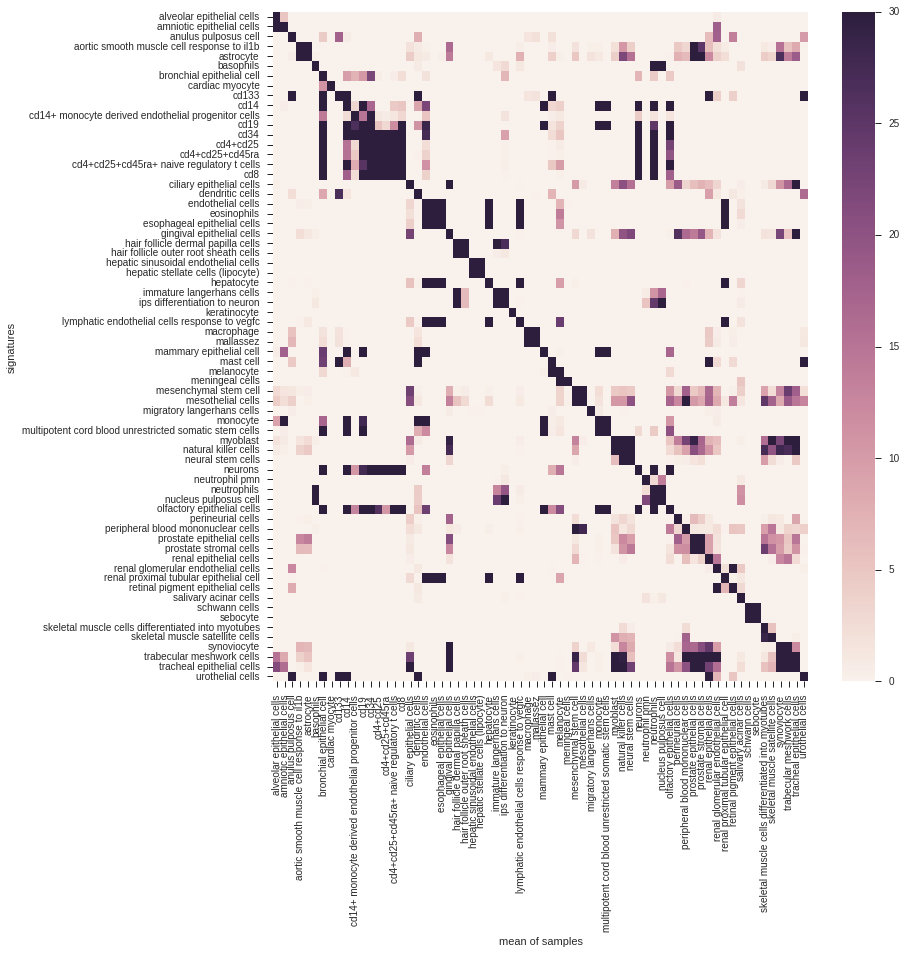

In [52]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(scores_per_sig, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

#### export signatures

In [56]:
rogini_good.to_csv("../results/primary.hq.gini", sep="\t", index=False)
rogini_bad.to_csv("../results/primary.lq.gini", sep="\t", index=False)
write_gmt(signatures_good, "../results/primary.hq.gmt")
write_gmt(signatures_bad, "../results/primary.lq.gmt")

In [57]:
good_samples.to_csv("../results/primary.sample_ids.hq.csv", index=False)
bad_samples.to_csv("../results/primary.sample_ids.lq.csv", index=False)